<a href="https://colab.research.google.com/github/Ataskmaster/deepfake-detection/blob/main/model_and_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from google_drive_downloader import GoogleDriveDownloader
import numpy as np
import os
import sys
import cv2
import glob
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torchvision import models
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Check if the file is corrupted or not
def validate_video(vid_path,train_transforms):
      transform = train_transforms
      count = 20
      video_path = vid_path
      frames = []
      file_name = video_path.split('/')[-1]
      for i,frame in enumerate(extract_frame(video_path)):
        frames.append(transform(frame))
        if(len(frames) == count):
          break
      frames = torch.stack(frames) # Concatenates a sequence of tensors along a new dimension
      frames = frames[:count]    
      return frames                # return stack of frames

In [ ]:
# extract a frame from video
def extract_frame(path):
  video_obj = cv2.VideoCapture(path) 
  success = 1
  while success:
      success, image = video_obj.read() #read a single image from video
      if success:
          yield image                   #yield the image if successfull

im_size = 112 #set fixed image size
mean = [0.485, 0.456, 0.406] #precalculated mean
std = [0.229, 0.224, 0.225] #precalculated standard deviation

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),              #Convert a tensor or an ndarray to PIL Image
                                        transforms.Resize((im_size,im_size)), #Resize to 112 x 112 pixels
                                        transforms.ToTensor(),                #Convert to tensor
                                        transforms.Normalize(mean,std)])      #normalise on provided mean and standard deviation

videos =  glob.glob('/content/gdrive/MyDrive/deepfake_dataset_face_only/*.mp4') #loads all video paths into videos array

print("Total number of videos :" , len(videos))

count = 0
for video in videos:
  try:
    count+=1
    validate_video(video,train_transforms)
    if count%50==0:
      print("count", count)
  except:                                                                                #if try block throws an error while validationg a video, the video is corrupted
    print("Number of video processed: " , count ," Remaining : " , (len(videos) - count)) 
    print("Corrupted video is : " , video)
    continue
print((len(videos) - count))

Total number of videos : 6450
count 50
count 100
count 150
count 200
count 250
count 300
count 350
count 400
count 450
count 500
count 550
count 600
count 650
count 700
count 750
count 800
count 850
count 900
count 950
count 1000
count 1050
count 1100
count 1150
count 1200
count 1250
count 1300
count 1350
count 1400
count 1450
count 1500
count 1550
count 1600
count 1650
count 1700
count 1750
count 1800
count 1850
count 1900
count 1950
count 2000
count 2050
count 2100
count 2150
count 2200
count 2250
count 2300
count 2350
count 2400
count 2450
count 2500
count 2550
count 2600
count 2650
count 2700
count 2750
count 2800
count 2850
count 2900
count 2950
count 3000
count 3050
count 3100
count 3150
count 3200
count 3250
count 3300
count 3350
count 3400
count 3450
count 3500
count 3550
count 3600
count 3650
count 3700
count 3750
count 3800
count 3850
count 3900
count 3950
count 4000
count 4050
count 4100
count 4150
count 4200
count 4250
count 4300
count 4350
count 4400
count 4450
count 4500


In [ ]:
#to remove videos with less number of frames
video_files = glob.glob('/content/gdrive/MyDrive/deepfake_dataset_face_only/*.mp4')
random.shuffle(video_files)

n_frames = []          #array containing number of frames in each video
for i,video_file in enumerate(video_files):
  if i%150==0:
    print(i)
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100): #if video has less than 100 frames, remove the video
    video_files.remove(video_file)
    continue
  n_frames.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , n_frames)
print("Total number of videos: " , len(n_frames))
print('Average frames per video:',np.mean(n_frames))

In [ ]:
#defining a video dataset class
class video_dataset(Dataset):
    def __init__(self,v_names,labels,sequence_length = 60,transform = None):
        self.v_names = v_names
        self.labels = labels
        self.count = sequence_length
        self.transform = transform
    def __len__(self):            #returns length if dataset (no. of videos)
        return len(self.v_names)
    def __getitem__(self,idx):    #returns the stack of frames and label of a video at given index
        video_path = self.v_names[idx]
        frames = []
        file_name = video_path.split('/')[-1]
        label = self.labels.iloc[(labels.loc[labels["file"] == file_name].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.extract_frame(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames,label
    def extract_frame(self,path):
      video_obj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = video_obj.read()
          if success:
              yield image

# plot the image
def image_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [ ]:
header_list = ["file","label"]
labels = pd.read_csv('/content/gdrive/MyDrive/Global_metadata.csv',names=header_list)
print("labels: \n",labels.head(5))
print(labels.shape)

labels: 
           file label
0      000.mp4  REAL
1  000_003.mp4  FAKE
2      001.mp4  REAL
3  001_870.mp4  FAKE
4      002.mp4  REAL
(23186, 2)


In [ ]:
def no_of_real_and_fake_videos(video_files):
  real=0
  fake=0
  for video_file in video_files:
    # print(video_file)
    file_name = video_file.split('/')[-1] #extract filename from file path
    try:
      label = labels.iloc[(labels.loc[labels["file"] == file_name].index.values[0]),1]
      if(label == 'FAKE'):
        fake+=1
      if(label == 'REAL'):
        real+=1
    except:
      print("error")
  return real,fake



number of train videos :  5160
number of test videos :  1290
error
error
TRAIN:  Real: 2648  Fake: 2511


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TEST:  Real: 660  Fake: 630


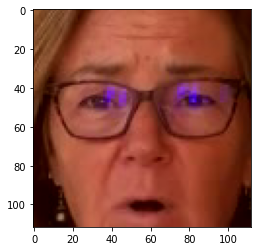

In [ ]:
#splitting video files into 80% training dataset and 20% test or validation dataset
train_videos = video_files[:int(0.8*len(video_files))] 
valid_videos = video_files[int(0.8*len(video_files)):]
print("number of train videos : " , len(train_videos))
print("number of test videos : " , len(valid_videos))

print("TRAIN: ", "Real:",no_of_real_and_fake_videos(train_videos)[0]," Fake:",no_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",no_of_real_and_fake_videos(valid_videos)[0]," Fake:",no_of_real_and_fake_videos(valid_videos)[1])


im_size = 112 #image size
mean = [0.485, 0.456, 0.406] #precalculated mean
std = [0.229, 0.224, 0.225] #precaulculated standard deviation

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_videos,labels,sequence_length = 60,transform = train_transforms) # creating train dataset

val_data = video_dataset(valid_videos,labels,sequence_length = 60,transform = train_transforms)   # creating test dataset
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
image,label = train_data[0]
image_plot(image[0,:,:,:]) #pritning a random image to check

In [ ]:
#Model 

class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2]) #removing last two dense layers
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional) #lstm
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        f_map = self.model(x)
        x = self.avgpool(f_map)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return f_map,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [ ]:
model = Model(2).cuda() #moving model to GPU
_,_ = model(torch.from_numpy(np.empty((1,60,3,112,112))).type(torch.cuda.FloatTensor)) #initialising model

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [ ]:
class AverageMeter(object):
    # Computes and stores the average and current value
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    # calculating running average using sum and count
    # n=batch size
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
# calculates accuracy
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)
    _, pred = outputs.topk(1, 1, True)  # topk() returns the k largest elements of the given input tensor along a given dimension
    pred = pred.t()                     # transpose
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [ ]:
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    # for calculating running averages of losses and accuarcies
    losses = AverageMeter() 
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor) # moving targets to GPU
            inputs = inputs.cuda()                        # moving targets to GPU
        _,outputs = model(inputs)                         # output from model
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor)) #get loss
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor)) #get accuracy
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/gdrive/MyDrive/checkpoint.pt')
    return losses.avg,accuracies.avg

In [ ]:
def test(epoch,model, data_loader ,criterion):
    print('\nTesting....')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor) #moving targets to GPU
                inputs = inputs.cuda() #moving input to GPU
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print(f'\nAccuracy {accuracies.avg}')
    return true,pred,losses.avg,accuracies.avg

In [ ]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [ ]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()



In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5
#number of epochs 
num_epochs = 20
 
optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)
 
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

[Epoch 1/20] [Batch 1285 / 1286] [Loss: 0.617341, Acc: 63.06%]Testing
[Batch 321 / 322]  [Loss: 0.472412, Acc: 76.44%]
Accuracy 76.43856920684293
[Epoch 2/20] [Batch 1285 / 1286] [Loss: 0.499727, Acc: 74.54%]Testing
[Batch 321 / 322]  [Loss: 0.388927, Acc: 83.90%]
Accuracy 83.90357698289269
[Epoch 3/20] [Batch 1285 / 1286] [Loss: 0.448136, Acc: 77.28%]Testing
[Batch 321 / 322]  [Loss: 0.357698, Acc: 83.44%]
Accuracy 83.43701399688958
[Epoch 4/20] [Batch 1285 / 1286] [Loss: 0.408047, Acc: 79.54%]Testing
[Batch 321 / 322]  [Loss: 0.297321, Acc: 88.26%]
Accuracy 88.25816485225505
[Epoch 5/20] [Batch 1285 / 1286] [Loss: 0.368182, Acc: 80.98%]Testing
[Batch 321 / 322]  [Loss: 0.272379, Acc: 88.26%]
Accuracy 88.25816485225505
[Epoch 6/20] [Batch 1285 / 1286] [Loss: 0.321820, Acc: 83.99%]Testing
[Batch 321 / 322]  [Loss: 0.295989, Acc: 87.87%]
Accuracy 87.86936236391912
[Epoch 7/20] [Batch 384 / 1286] [Loss: 0.265957, Acc: 86.62%]

KeyboardInterrupt: ignored

6


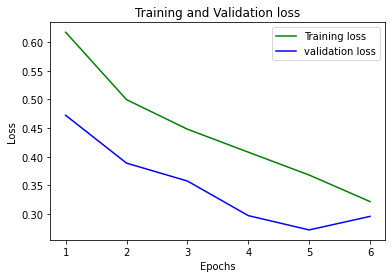

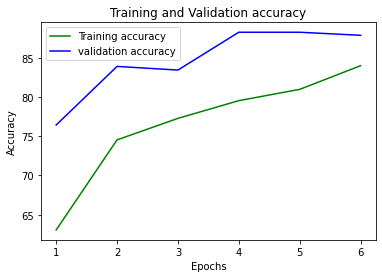

[[561  72]
 [ 84 569]]
True positive =  561
False positive =  72
False negative =  84
True negative =  569




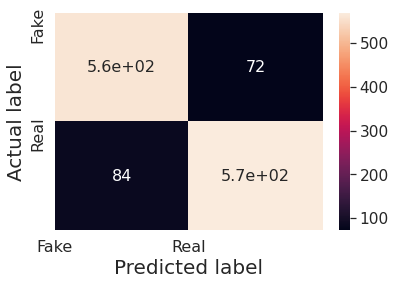

Calculated Accuracy 87.86936236391914


In [ ]:
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)